In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from curve_models import NLLS, NLLS_w, NLLS_rse, power_law, CurveModel, linearized_power_law

ss = np.loadtxt('../ss')
mses = np.loadtxt('../mses')
test_mses = np.loadtxt('../test_mses')



train_pt = 29
forget_pt = 22
nlls = NLLS(power_law)
nlls.fit(ss[:train_pt], mses[:train_pt])

nlls_w = NLLS_w(power_law)
nlls_w.fit(ss[:train_pt], mses[:train_pt])

nlls_rse = NLLS_rse(linearized_power_law, name='NLS_rse')
nlls_rse.fit(ss[forget_pt:train_pt], mses[forget_pt:train_pt])

n_eval_steps = max(ss)
x_samples = list(range(1, int(n_eval_steps), 100))
nlls_y = [nlls.f(x, **nlls.p) for x in x_samples]
nlls_w_y = [nlls_w.f(x, **nlls_w.p) for x in x_samples]
nlls_rse_y = [nlls_rse.f(x, **nlls_rse.p) for x in x_samples]

[[2.98617982e-12 1.20141662e-05]
 [1.20141662e-05 4.85995755e+01]]


(100000.0, 160000.0)

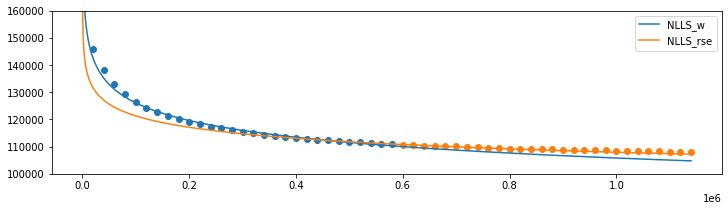

In [85]:
fig= plt.figure(figsize=(12,3))
plt.scatter(ss[:train_pt], mses[:train_pt])
plt.scatter(ss[train_pt:], mses[train_pt:])

plt.plot(x_samples, nlls_w_y, label="NLLS_w")
plt.plot(x_samples, nlls_rse_y, label="NLLS_rse")
plt.legend()
plt.ylim(100000, 160000)
# plot the best mse
# plot the worst mse
# plot 

In [113]:
expmt = "ml-20m-uniform_5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8"
data = pd.read_csv('../results/forecasting/' + expmt + '/results_df')
n_init = data['n_init'][0]
n_observable = 1179131
worst_mse = data[data['run'] == 4]['worst_mse'].iloc[0]
best_mse = data[data['run'] == 4]['best_mse'].iloc[0]

In [230]:
# Calculate predicted percentage based on fully fit curve
# Fit curves based on that amount of data, predict for n_init, n_available, n_total
# Get real percentage using validation MSE, worst_mse, and best_mse

pred_pcts = []
true_pcts = []
pred_worsts, pred_bests, pred_currs = [], [], []
true_mses = []
for i, (size, mse) in enumerate(zip(ss, mses)):
    if size < n_init:
        continue
    # Fit curve for all points in ss and mses through pt i
    start_cm = NLLS_rse(linearized_power_law)
    start = 0
    end = np.min([9, i+1])
    start_cm.fit(ss[start:end], mses[start:end])
    
    end_cm = NLLS_rse(linearized_power_law)
    start = np.max([0, i+1-5])
    end_cm.fit(ss[start:i+1], mses[start:i+1])
    
    # Calculate predicted percentage of total performance
    pred_worst = start_cm.f(n_init, **start_cm.p)
    pred_best = end_cm.f(n_observable, **end_cm.p)
    pred_curr = end_cm.f(size, **end_cm.p)

    pred_pct = (pred_worst - pred_curr)/(pred_worst - pred_best)
    # Calculate true percentage of total performance
    true_pct = (worst_mse - mse)/(worst_mse - best_mse)
    pred_pcts.append(pred_pct)
    true_pcts.append(true_pct)
    pred_worsts.append(pred_worst)
    pred_bests.append(pred_best)
    pred_currs.append(pred_curr)
    true_mses.append(mse)
    

(120000.0, 123000.0)

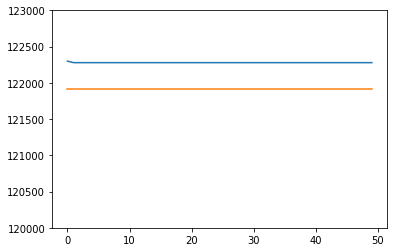

In [231]:
plt.plot(np.arange(len(pred_worsts)), pred_worsts )
plt.plot(np.arange(len(pred_worsts)), [worst_mse for i in range(len(pred_worsts))] )

# plt.plot(np.arange(len(pred_worsts)), pred_bests )
# plt.plot(np.arange(len(pred_worsts)), [best_mse for i in range(len(pred_worsts))] )

# plt.plot(np.arange(len(pred_worsts)), pred_currs )
# plt.plot(np.arange(len(pred_worsts)), true_mses )
plt.ylim(120000, 123000)

(0.1, 0.9)

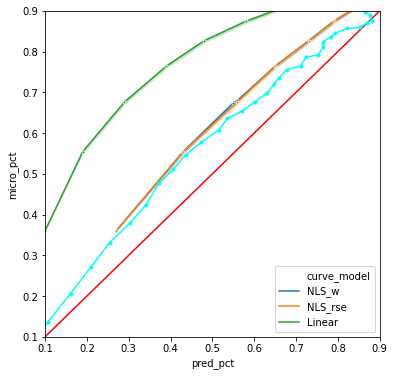

In [234]:
fig= plt.figure(figsize=(6,6))
data = data.round({'pred_pct': 2, 'micro_pct': 2, 'pct_available': 2})
sns.lineplot(x='pred_pct', y='micro_pct', hue='curve_model', data=data[data['curve_model'] != 'Initial'], marker='.')
plt.plot([i for i in np.arange(.1, 1, .1)], [i for i in np.arange(.1, 1, .1)], c='r')
plt.plot(pred_pcts, true_pcts, c='cyan', marker='.')
plt.ylim(.1, .9)
plt.xlim(.1, .9)

In [154]:
old_pred_pcts = pred_pcts.copy()

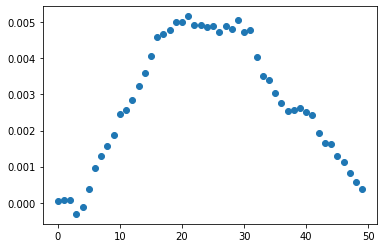

In [162]:
plt.scatter(np.arange(len(pred_pcts)), np.array(old_pred_pcts) - np.array(pred_pcts))